Bayan Nezamabad - 20251971, Euan Bourke - 21332142

In [73]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from keras import utils, Sequential, layers, optimizers
import time
from sklearn import metrics

In [2]:
# Hyper Params
EPOCHS = 50
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = optimizers.Adam(learning_rate=0.001)
LOSS = "categorical_crossentropy"
METRICS = ["accuracy", "precision", "recall"]

IMG_ROW, IMG_COL = 227, 227 # Image dimensions
INPUT_SHAPE = (IMG_ROW, IMG_COL, 3) # 3 as RGB
NB_CLASSES = 100 # 100 different classifications for 100 different species of butterfly or moth

TRAIN_PATH = "data/train"
VALID_PATH = "data/valid"
TEST_PATH = "data/test"
SEED = 123 # used for consistent randomisation of the dataset

In [75]:
# Loading and preparing training, validation, and testing data
# Images are originally 224x224 so we have to resize them to 227x227, the input size of AlexNet
train_data = utils.image_dataset_from_directory(TRAIN_PATH,
                                                shuffle=True,
                                                image_size=(IMG_COL, IMG_ROW), # Images are resized to 227 x 227
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                label_mode="categorical")
valid_data = utils.image_dataset_from_directory(VALID_PATH,
                                                shuffle=True,
                                                image_size=(IMG_COL, IMG_ROW), # Images are resized to 227 x 227
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                label_mode="categorical")
    
test_data = utils.image_dataset_from_directory(TEST_PATH,
                                               shuffle=False,
                                               image_size=(IMG_COL, IMG_ROW), # Images are resized to 227 x 227
                                               batch_size=BATCH_SIZE,
                                               label_mode="categorical")

# Min-max normalisation scales all values to the range 0 - 1
# Division by 255 accomplishes this since the max value for any pixel in any colour channel is 255
train_data = train_data.map(lambda x, y: (x / 255.0, y))
valid_data = valid_data.map(lambda x, y: (x / 255.0, y))
test_data = test_data.map(lambda x, y: (x / 255.0, y))

Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [4]:
# Implementation of AlexNet architecture
class AlexNet(Sequential):
    def __init__(self):
        super().__init__()
        self.build_layers()
        # Compiles the model with our chosen optimiser, loss function, and metrics
        self.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    def build_layers(self):
        # The architecture consists of 5 convolutional layers, 3 max pooling layers, 1 flatten layer, 3 fully connected layers (dropout following the first two), and an output layer
        
        # First convolutional layer consists of 96 filters, kernel size of 11x11, and moves in strides of 4
        # This results in an output shape 55x55x96
        self.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation="relu", input_shape=INPUT_SHAPE))
        self.add(layers.BatchNormalization())
        # In max pooling we take the max value of a 3x3 region and move in strides of 2
        # Resultant shape: 27x27x96
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

        # The resultant shape should be 27x27x256 so we apply even padding
        self.add(layers.Conv2D(256, (5, 5), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())
        # Resultant shape: 13x13x256
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

        # Three more convolutional layers, only dimension changing here is z
        self.add(layers.Conv2D(384, (3, 3), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())
        self.add(layers.Conv2D(384, (3, 3), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())
        self.add(layers.Conv2D(256, (3, 3), padding="same", activation="relu"))
        self.add(layers.BatchNormalization())

        # Last max pooling layer results in 6x6x256
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

        # Flatten layer results in 1x1x9216 (6*6*256 = 9216)
        self.add(layers.Flatten())

        # Fully connected layers with dropout to prevent overfitting
        self.add(layers.Dense(4096, activation="relu"))
        # 50% chance for each neuron to be deactivated
        # Prevents overfitting by preventing over reliance on a specific feature and instead learning a more robust set of features
        self.add(layers.Dropout(rate=0.5))
        
        self.add(layers.Dense(4096, activation="relu"))
        self.add(layers.Dropout(rate=0.5))
        
        self.add(layers.Dense(1000, activation="relu"))
        
        # Softmax converts the input into probabilities for each class, emphasising the difference between input values
        self.add(layers.Dense(NB_CLASSES, activation="softmax"))

model = AlexNet()
model.summary()

C:\Users\bayan\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "alex_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │       100,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,483,948 (238.36 MB)

 Trainable params: 62,481,196 (238.35 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [5]:
# Training our model

training_start_time = time.time()
# Training
model_history = model.fit(train_data, epochs=EPOCHS, validation_data=valid_data, verbose=VERBOSE)
training_end_time = time.time()
total_training_time = training_end_time - training_start_time

# Displaying the total training time in minutes and seconds
print(f"Total training time: {total_training_time/60:.0f}m{total_training_time%60:.0f}s")

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.0364 - loss: 8.5226 - precision: 0.0270 - recall: 0.0027 - val_accuracy: 0.0300 - val_loss: 5.1316 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.1440 - loss: 3.4992 - precision: 0.3722 - recall: 0.0273 - val_accuracy: 0.0580 - val_loss: 4.5952 - val_precision: 0.0769 - val_recall: 0.0020
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.2184 - loss: 3.0310 - precision: 0.4768 - recall: 0.0707 - val_accuracy: 0.1460 - val_loss: 3.7227 - val_precision: 0.4074 - val_recall: 0.0220
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3106 - loss: 2.6281 - precision: 0.5686 - recall: 0.1429 - val_accuracy: 0.3420 - val_loss: 2.5215 - val_precision: 0.7108 - val_recall: 0.1180
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3787 - loss: 2.3217 - precision: 0.6342 - recall: 0.2114 - val_accuracy: 0.4580 - val_

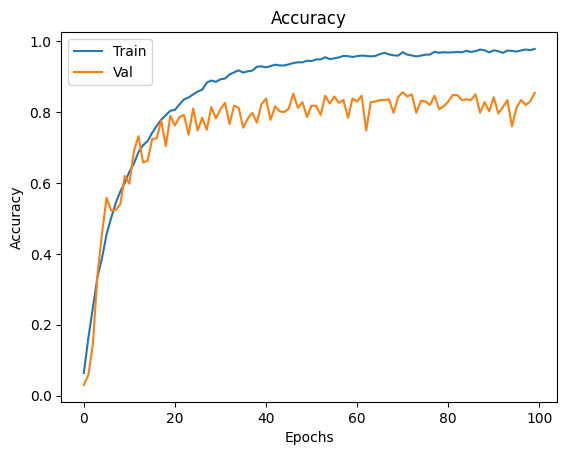

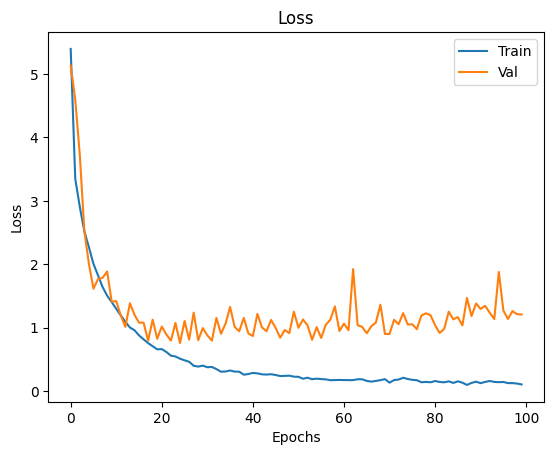

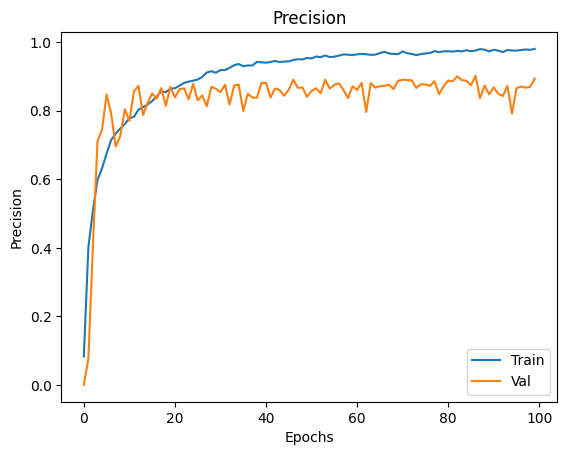

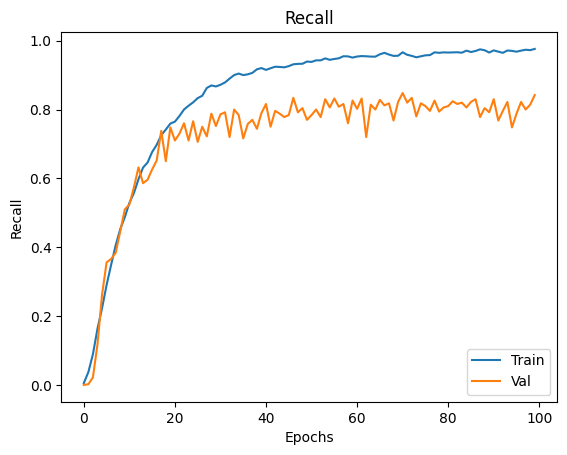

In [90]:
# Obtaining metrics from training
training_accuracy = model_history.history["accuracy"]
training_precision = model_history.history["precision"]
training_recall = model_history.history["recall"]
training_loss = model_history.history["loss"]

# Obtaining metrics from validation
validation_accuracy = model_history.history["val_accuracy"]
validation_precision = model_history.history["val_precision"]
validation_recall = model_history.history["val_recall"]
validation_loss = model_history.history["val_loss"]

# Visualising training results over time
# Plotting model accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Plotting model loss
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

# Plotting model precision
plt.plot(training_precision)
plt.plot(validation_precision)
plt.title("Precision")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

# Plotting model recall
plt.plot(training_recall)
plt.plot(validation_recall)
plt.title("Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

In [99]:
# Extracting test images and labels from the dataset
X_test = [] # Array of images
y_test = [] # Array of labels corresponding to the images
for x, y in test_data.as_numpy_iterator():
  X_test.extend(x)
  y_test.extend(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluating model against test data
model_results = model.evaluate(X_test, y_test, verbose=VERBOSE)

print("Test loss: ", round(model_results[0], 4))
print("Test accuracy: ", round(model_results[1]*100, 1), "%")
print("Test Precision: ", round(model_results[2]*100, 1), "%")
print("Test Recall: ", round(model_results[3]*100, 1), "%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8680 - loss: 1.1005 - precision: 0.9018 - recall: 0.8536
Test loss:  1.0157
Test accuracy:  88.6 %
Test Precision:  90.0 %
Test Recall:  86.8 %


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


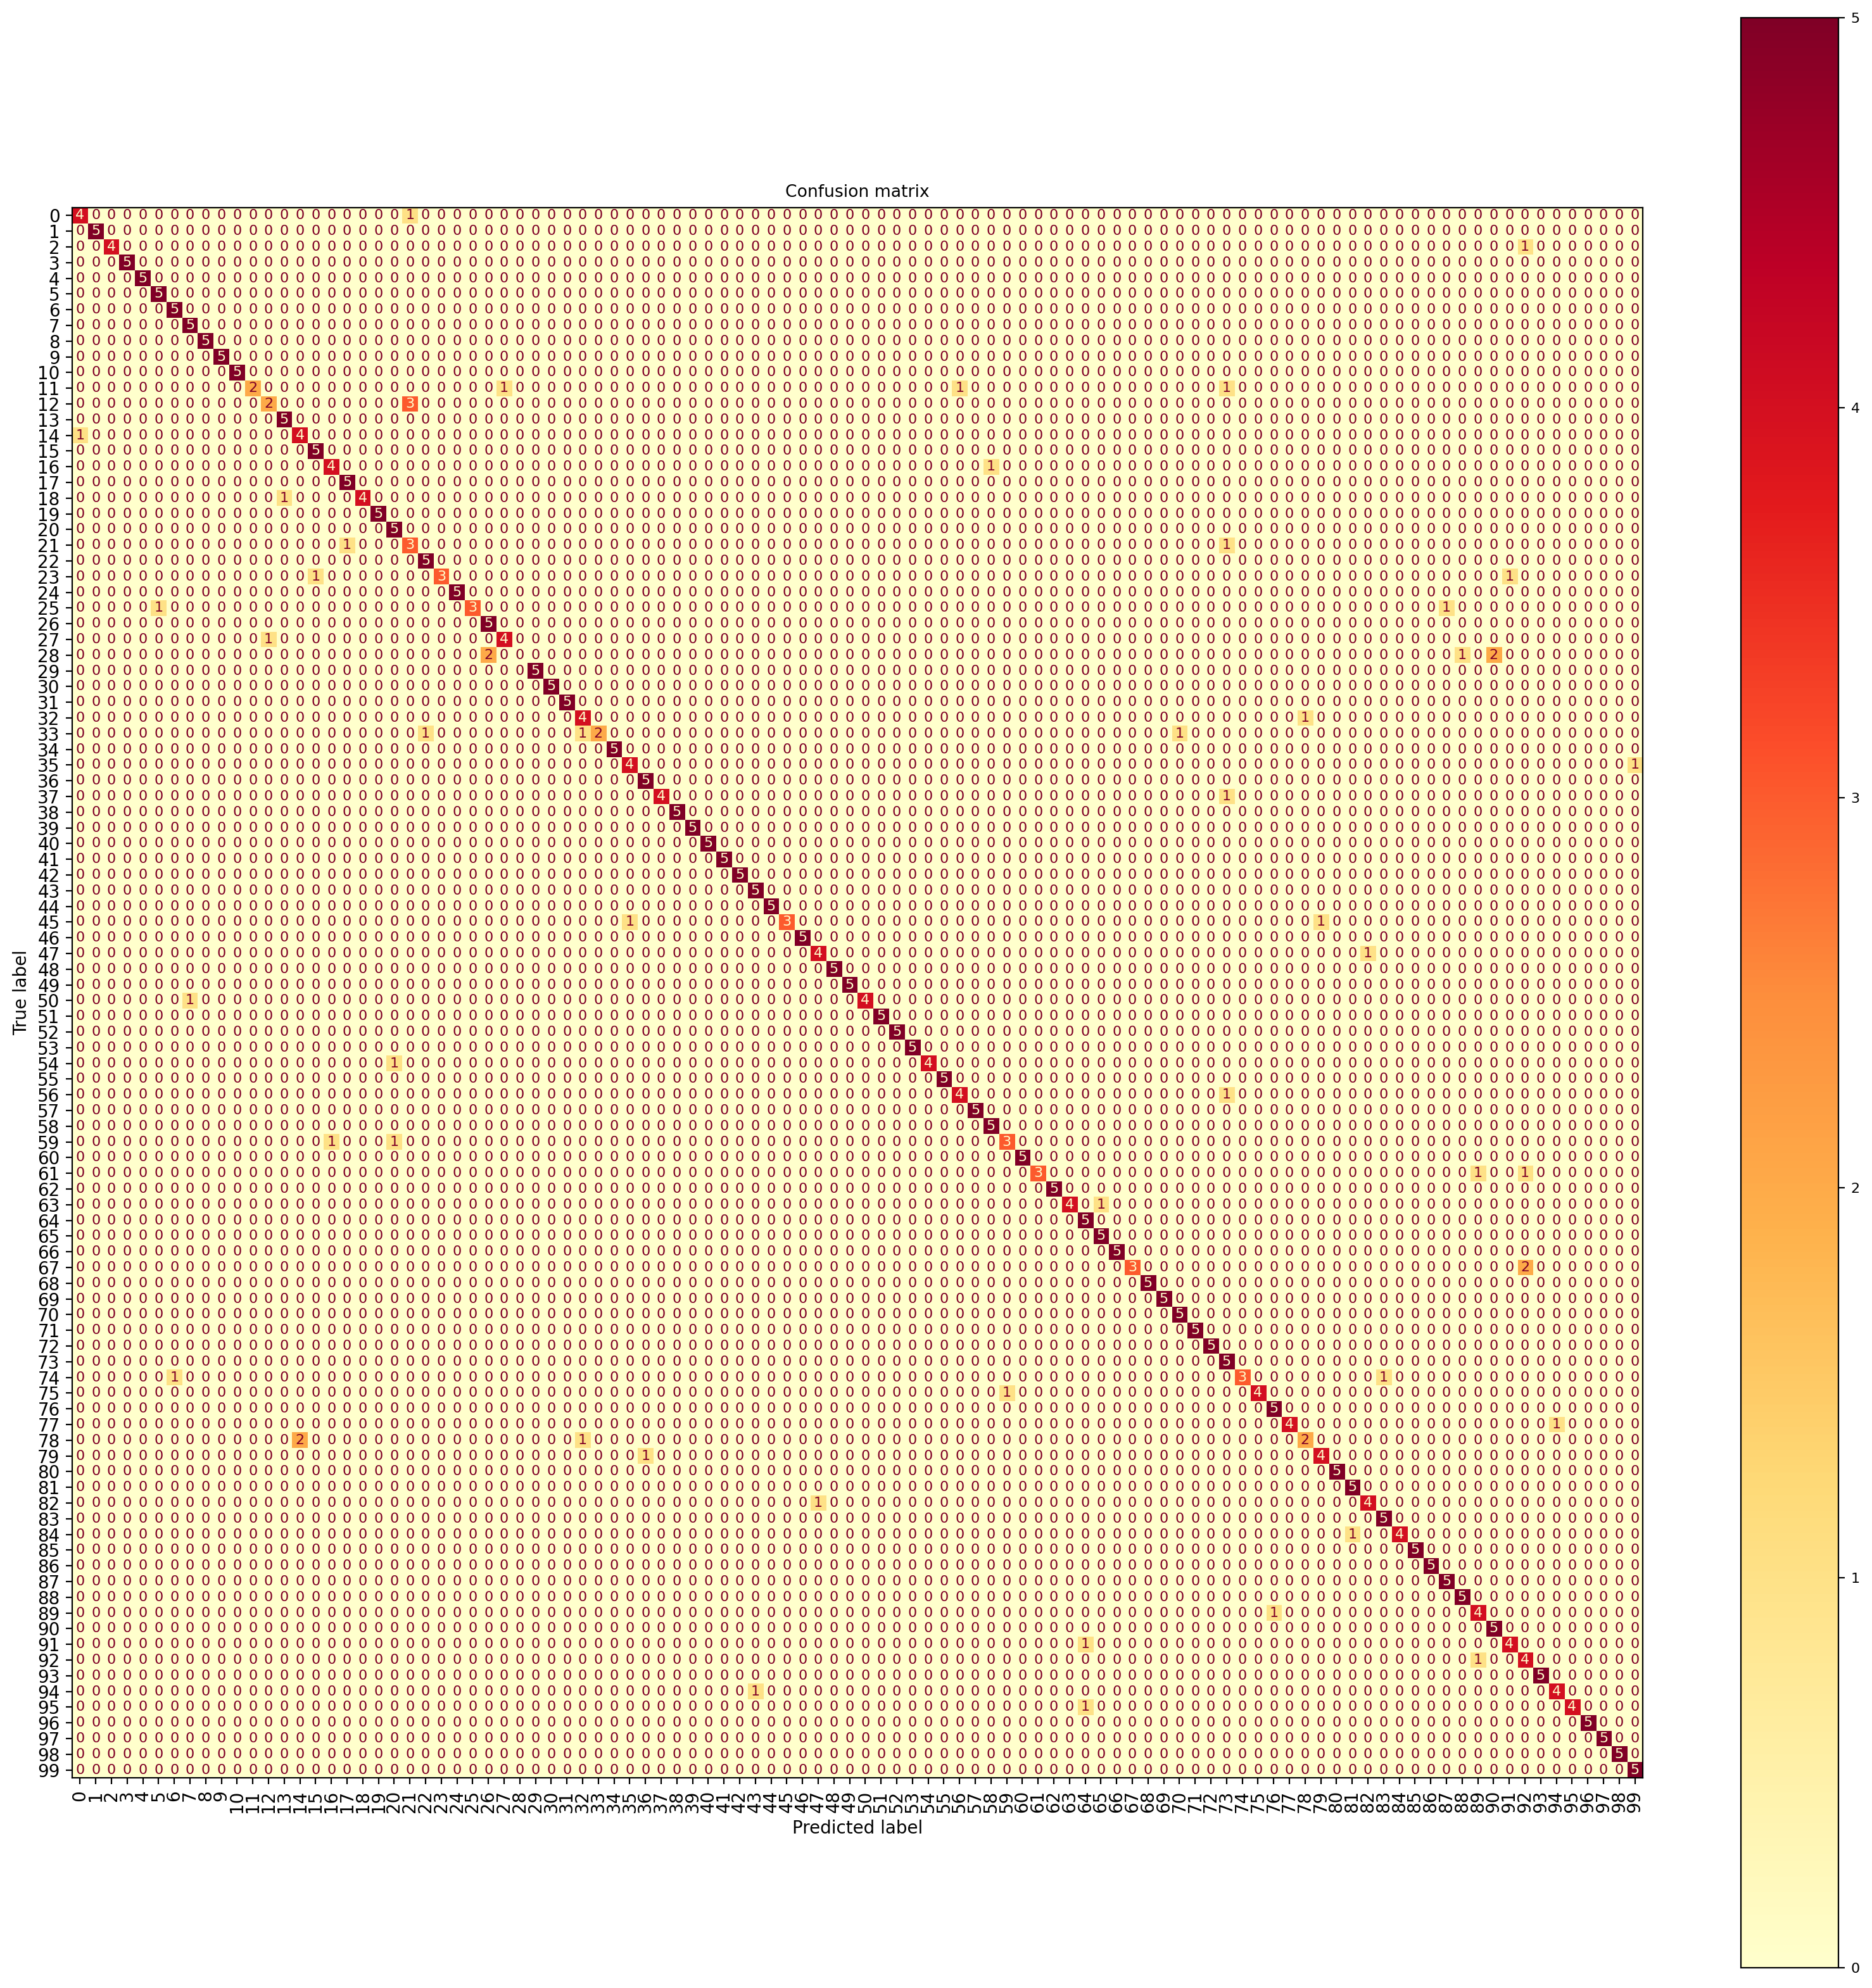

In [132]:
# Visualising test results
# Getting predicted and actual results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Computing confusion matrix
cm = metrics.confusion_matrix(y_true_classes, y_pred_classes)
classes = [str(i) for i in range(NB_CLASSES)]
cm_display = metrics.ConfusionMatrixDisplay(cm)

# The matrix is 100x100 so the following lines make it a bit more visually accessible
fig, ax = plt.subplots(figsize=(20, 20), dpi=200)
plt.rcParams.update({"font.size": 8})

# Plotting confusion matrix
cm_display.plot(ax=ax, cmap="YlOrRd", xticks_rotation="vertical")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

Refs: \
AlexNet Architecture: https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide \
https://medium.com/@siddheshb008/alexnet-architecture-explained-b6240c528bd5
Keras.layer docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/
